In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt 

# Extracting necessary SINMOD data

Extracting more than a few time steps will take a while and potentially cause crashing. Then we will need to run on IDUN. Can set up via VS code ssh.

We will now:
- Look at a few data sets to check the numbers make sense
- Standardise and normalise the data

In [2]:
import netCDF4 as nc
from netCDF4 import Dataset

# Importing SINMOD data
filename_PhysStates = 'PhysStates.nc'

PhysStates_data = Dataset(filename_PhysStates, 'r')

# Looking at our list of available variables
variables_list = list(PhysStates_data.variables.keys())
for variable in variables_list:
    units = PhysStates_data.variables[variable].units if 'units' in PhysStates_data.variables[variable].ncattrs() else 'No units'
    print(f"{variable:<20} {units}")

time                 No units
grid_mapping         No units
LayerDepths          m
xc                   meter
yc                   meter
zc                   m
depth                m
DXxDYy               m2
u_velocity           m/s
v_velocity           m/s
elevation            m
temperature          degC
salinity             psu
ice_thickness        m
ice_compactness      -
salinity_ice         psu


In [3]:
# Extracting all the map dimensions, we can extract both ways, I don't think it matters
xc = PhysStates_data.variables['xc'][:]  # x-coordinates (meters)
yc = PhysStates_data.variables['yc'][:]  # y-coordinates (meters)
zc = PhysStates_data['LayerDepths'][:]  # z-coordinates (meters)

# Now checking temperature data matches what we expect from the dimensions
# Extracting temperature at t = 0, and check the dimensions
temperature_var = PhysStates_data.variables['temperature']
temperature = temperature_var[0,:,:,:]
print("SINMOD grid dimensions:")
print(f"xc shape: {xc.shape}")
print(f"yc shape: {yc.shape}")
print(f"zc shape: {zc.shape}")

print(f"\nTemperature data shape: {temperature.shape}")
# Now checking mean, max and min temperature to see if it makes sense
print(f"Mean temperature:\t{temperature.mean():.2f}")
print(f"Max temperature:\t{temperature.max():.2f}")
print(f"Min temperature:\t{temperature.min():.2f}")

# Repeating for salinity
salinity_var = PhysStates_data.variables['salinity']
salinity = salinity_var[0,:,:,:]

print(f"\nSalinity data shape:\t{salinity.shape}")
print(f"Mean salinity:\t\t{salinity.mean():.2f}")
print(f"Max salinity:\t\t{salinity.max():.2f}")
print(f"Min salinity:\t\t{salinity.min():.2f}")


SINMOD grid dimensions:
xc shape: (300,)
yc shape: (235,)
zc shape: (25,)

Temperature data shape: (25, 235, 300)
Mean temperature:	1.89
Max temperature:	11.51
Min temperature:	-1.80

Salinity data shape:	(25, 235, 300)
Mean salinity:		34.14
Max salinity:		37.37
Min salinity:		0.10


In [4]:
from sklearn.preprocessing import StandardScaler

# Many options for what sort of standardisation we want here, but a simple one:
# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the temperature and salinity data
temperature_standardized = scaler.fit_transform(temperature.reshape(-1, 1)).reshape(temperature.shape)
salinity_standardized = scaler.fit_transform(salinity.reshape(-1, 1)).reshape(salinity.shape)

# Print the mean and standard deviation of the standardized data to verify
print(f"Standardized Temperature - Mean: {temperature_standardized.mean():.2f}, Std Dev: {temperature_standardized.std():.2f}")
print(f"Standardized Salinity - Mean: {salinity_standardized.mean():.2f}, Std Dev: {salinity_standardized.std():.2f}")

Standardized Temperature - Mean: 0.00, Std Dev: 1.00
Standardized Salinity - Mean: -0.00, Std Dev: 1.00


Now repeating for Biostates

In [5]:
import geopandas as gpd
import pandas as pd
# Importing coral reef data

# gml_file_coral_reefs = "./KystOgFiskeri_50_Trondelag_25832_Korallrev_GML.gml"
gml_file_coral_reefs = "KystOgFiskeri_50_Trondelag_25833_Korallrev_GML.gml"

gdf_coral_reefs = gpd.read_file(gml_file_coral_reefs)

# Not sure this is necessary since all the naturtypeNavn are the same
# unique_naturtypeNavn = gdf_coral_reefs['naturtypeNavn'].unique()
# print(unique_naturtypeNavn)
coral_data = gdf_coral_reefs[gdf_coral_reefs['naturtypeNavn'] == 'Korallforekomster']

# I think it's already a dataframe, so also unnecessary
coral_df = pd.DataFrame(coral_data)


coral_location_df = coral_df[['lengdegrad', 'breddegrad']]

In [6]:
# Check what metadata we have with the coral reef data
# We can use this later for grouping or further analysis
 
# Display the columns of the coral reef data
print(coral_df.columns)

Index(['gml_id', 'lokalId', 'navnerom', 'verifiseringsdato', 'produkt',
       'versjon', 'målemetode', 'nøyaktighet', 'medium', 'opphav',
       'minimumsdybde', 'maksimumsdybde', 'naturtype', 'naturtypeNavn',
       'kildeNavn', 'observasjonsMetode', 'observasjonsSted',
       'observasjonsSlutt', 'lengdegrad', 'breddegrad', 'geometry'],
      dtype='object')


In [7]:
# Now to transform the coordinates to the same projection as the SINMOD data

from pyproj import CRS, Transformer

# Print grid mapping to see what the horizontal resolution is
# In the case of gin it is 20km, for nor4km it is 4km
grid_mapping = PhysStates_data.variables['grid_mapping']
print(grid_mapping)


<class 'netCDF4._netCDF4.Variable'>
int32 grid_mapping()
    grid_mapping_name: polar_stereographic
    straight_vertical_longitude_from_pole: 58.0
    horizontal_resolution: 20000.0
    latitude_of_projection_origin: 90.0
    longitude_of_projection_origin: 58.0
    standard_parallel: 60.0
    origoRef: [0. 0.]
    semi_minor_axis: 6370000.0
    semi_major_axis: 6370000.0
    false_easting: 3900000.0
    false_northing: 2570000.0
    scale_factor_at_projection_origin: 1.0
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used


In [8]:
# Specifying projection to SINMOD format

# Define the Coordinate Reference Systems (CRS) for the coral data
# It could be any of these, need to double check
crs_wgs84 = CRS.from_epsg(4326)  # WGS84 (lat/lon coordinates)
# crs_euref89_utm32 = CRS.from_epsg(25832)  # EUREF89 / UTM zone 32N
# crs_euref89 = CRS.from_epsg(4258)  # EUREF89 (geographic lat/lon)

# SINMOD projection parameters as a custom projection
crs_sinmod = CRS.from_proj4("+proj=stere +lat_0=90 +lat_ts=60 +lon_0=58 "
                            "+x_0=3900000 +y_0=2570000 +ellps=WGS84 +units=m +no_defs")

# Create a transformer to transform from wgs84 (geographic) to SINMOD
transformer_wgs84_to_sinmod = Transformer.from_crs(crs_wgs84, crs_sinmod, always_xy=True)

xc_grid, yc_grid = np.meshgrid(xc, yc)
lon_grid, lat_grid = transformer_wgs84_to_sinmod.transform(xc_grid, yc_grid)

# Performing projection on coral reef data
print("coral_lons range before:", coral_location_df['lengdegrad'].min(), coral_location_df['lengdegrad'].max())
print("coral_lats range before:", coral_location_df['breddegrad'].min(), coral_location_df['breddegrad'].max())
print("--------------------------------")

# Transform coral coordinates from EUREF89 to SINMOD
coral_x, coral_y = transformer_wgs84_to_sinmod.transform(coral_location_df['lengdegrad'], coral_location_df['breddegrad'])

# We need to DIVIDE by the resolution of the SINMOD grid to get the grid coordinates
# In the case of gin this is 20km
coral_x /= 20000
coral_y /= 20000

# The values after are NOT lat lon, but rather the SINMOD grid coordinates 
print("coral_lons grid-coordinates after:", coral_x.min(), coral_x.max())
print("coral_lats grid-coordinates before:", coral_y.min(), coral_y.max())

# So we expect them to be in the range of the SINMOD grid:
print(f"Grid dimensions (xc): {xc.shape[0]}")
print(f"Grid dimensions (yc): {yc.shape[0]}")


coral_lons range before: 7.84797 11.32001
coral_lats range before: 63.4133 65.00816
--------------------------------
coral_lons grid-coordinates after: 87.50081214535975 98.74281827314783
coral_lats grid-coordinates before: 33.6640977812021 39.715041231478516
Grid dimensions (xc): 300
Grid dimensions (yc): 235


In [9]:
# Get the corner points of the grid in SINMOD
corners_sinmod = [
    (xc[0], yc[0]),  # bottom-left
    (xc[-1], yc[0]),  # bottom-right
    (xc[0], yc[-1]),  # top-left
    (xc[-1], yc[-1])  # top-right
]

transformer_sinmod_to_wgs84 = Transformer.from_crs(crs_sinmod, crs_wgs84, always_xy=True)

# Transform each corner to WGS84
corners_wgs84 = [transformer_sinmod_to_wgs84.transform(x, y) for x, y in corners_sinmod]

# Print the corners in WGS84
for i, (lon, lat) in enumerate(corners_wgs84):
    print(f"Corner {i + 1} in WGS84: Longitude = {lon}, Latitude = {lat}")

masked_array(
  data=[[inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        ...,
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf]],
  mask=False,
  fill_value=1e+20)

In [10]:
print(temperature.shape)
mean_temp = temperature.mean()
max_temp = temperature.max()
min_temp = temperature.min()

print(f"Mean temperature: {mean_temp:.2f}")
print(f"Max temperature: {max_temp:.2f}")
print(f"Min temperature: {min_temp:.2f}")

temperature[0,1,1]

(25, 235, 300)
Mean temperature: 1.89
Max temperature: 11.51
Min temperature: -1.80


masked

Depth index for 250m: 16


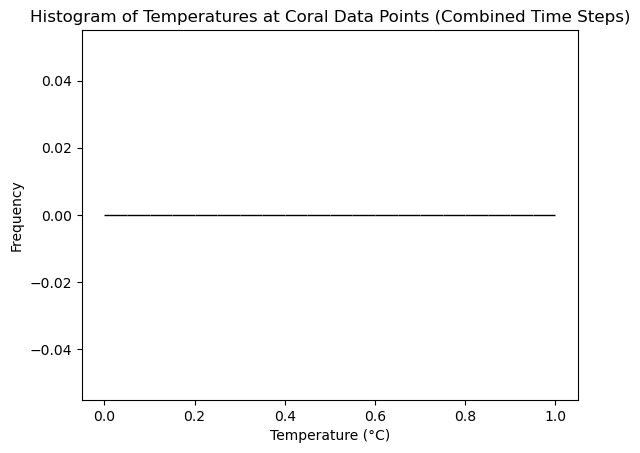

In [11]:
# Extracting u and v velocity components at t = 0 and depth closest to 250m
temperature_var = PhysStates_data.variables['temperature']

# Find the index of the depth closest to 250m
depth_index = np.abs(zc - 250).argmin()
print(f"Depth index for 250m: {depth_index}")

# Using the first 150 time steps
temperature = temperature_var[:150, depth_index, :, :]

# Extract temperature at coral data points
coral_temperatures = []
for time in range(temperature.shape[0]):
    for x, y in zip(coral_x, coral_y):
        # Ensure the coordinates are within the grid bounds
        if 0 <= x < temperature.shape[2] and 0 <= y < temperature.shape[1]:
            temp_value = temperature[time, int(y), int(x)]
            if not np.ma.is_masked(temp_value):
                coral_temperatures.append(temp_value)

# Convert list to numpy array for easier manipulation
coral_temperatures = np.array(coral_temperatures)

# Flatten the array to combine all time steps
coral_temperatures_flat = coral_temperatures.flatten()

# Plot histogram of the combined temperature values
plt.hist(coral_temperatures_flat, bins=20, edgecolor='black')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Histogram of Temperatures at Coral Data Points (Combined Time Steps)')
plt.show()

In [ ]:
# Extracting u and v velocity components at t = 0 and depth closest to 250m
u_velocity_var = PhysStates_data.variables['u_velocity']
v_velocity_var = PhysStates_data.variables['v_velocity']

# Using the first 100 time steps
u_velocity = u_velocity_var[:150, depth_index, :, :]
v_velocity = v_velocity_var[:150, depth_index, :, :]

# Calculate the magnitude of the current speed
current_speed = np.sqrt(u_velocity**2 + v_velocity**2)

# Extract current speed at coral data points
coral_current_speeds = []

for time in range(current_speed.shape[0]):
    for x, y in zip(coral_x, coral_y):
        # Ensure the coordinates are within the grid bounds
        if 0 <= x < current_speed.shape[2] and 0 <= y < current_speed.shape[1]:
            coral_current_speeds.append(current_speed[int(y), int(x)])

# Plot histogram of the current speed values
plt.hist(coral_current_speeds, bins=200, edgecolor='black')
plt.xlabel('Current Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Current Speeds at Coral Data Points')
plt.show()

/tmp/ipykernel_23870/2701508233.py:10: RuntimeWarning: invalid value encountered in sqrt
  current_speed = np.sqrt(u_velocity**2 + v_velocity**2)


0.0


np.float64(0.0)

In [72]:
current_speed.shape

(150, 235, 300)